Notebook to sketch methodology for occultation flagging.

TODO: What is an acceptble false positive rate?

TODO: approach is definitely parallisable

TODO: save (and load) template bank

TODO: subtract sky backgrounds

TODO: be sensible about what templates to trial on a source of a given brightness (save time)

Automate the workflow:

- Is it wise to blindly implement comparison star selection... probably not

In [1]:
# imports
from tqdm import tqdm # progressbar
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

### Differential photometry

In [2]:
# load data and generate a matrix of observations
#path = 'E:/McDonald backups/results_M11_Sept20_2'
#path = 'D:/McDonaldObs_Feb_2024/Results_16th_Feb/RUN_14/SCENE_0/photometry/'
#path = 'D:/McDonaldObs_Feb_2024/Results_16th_Feb/RUN_14/SCENE_0/photometry'
path = 'D:/McDonaldObs_Feb_2024/Results_18th_Feb/RUN_4/SCENE_0/photometry'

files = [f for d, s, f in os.walk(path)][0]

# order the files
phot_files = []
seq_files = []
sky_files = []
batch_ids = np.arange(0, 1000).astype(str)
for b in batch_ids:
    for f in files:
        if 'photometry' in f and 'batch' + b + '.npy' in f:
            phot_files.append(f)
        elif 'seq' in f and 'batch' + b + '.npy' in f:
            seq_files.append(f)
        elif 'sky' in f and 'batch' + b + '.npy' in f:
            sky_files.append(f)

In [3]:
positions = np.load(os.path.join(path, 'positions.npy'))
bb_pos = np.load(os.path.join(path, 'bb_pos.npy'))
positions.shape, bb_pos.shape

((48, 2), (8, 2))

In [4]:
n = 0 # use as reference for array dimensions
fs = np.load(os.path.join(path, phot_files[n])) # use for shape info
ss = np.load(os.path.join(path, sky_files[n]))
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

# staple together the data in files
def batch_files(files, arr):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(path, file))
    return arr

data = batch_files(phot_files, data)
t = batch_files(seq_files, t)
bkgs = batch_files(sky_files, bkgs)

In [5]:
# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
t = t.flatten().astype(np.float32)
data.shape, data.dtype, t.shape, t.dtype, bkgs.shape, bkgs.dtype

((281000, 48),
 dtype('float32'),
 (281000,),
 dtype('float32'),
 (281000, 8),
 dtype('float32'))

In [6]:
# generate observatons matrix (n_samples x n_features)
X = np.copy(data)
X.shape

(281000, 48)

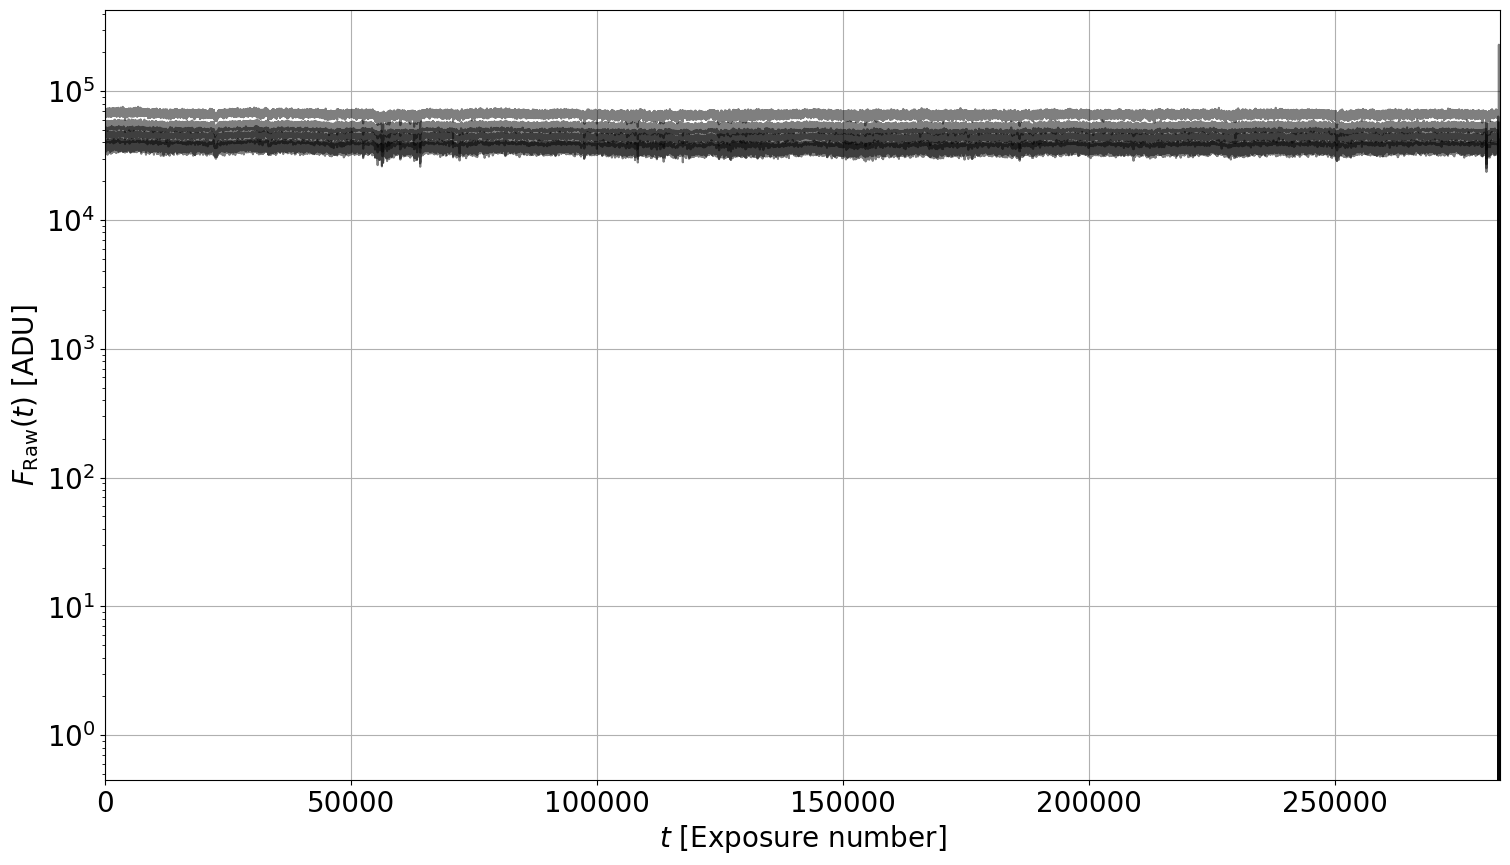

In [7]:
# by-eye check - should see co-trending behaviour
fs = 20
plt.figure(figsize=(18,10))
#stars = [0, 1, 25]
stars = [0, 1, 2, 3, 4, 5]
plt.plot(t, X[:, stars], c='black', alpha=0.5)
plt.ylabel('$F_{\mathrm{Raw}}(t)$ [ADU]', fontsize=fs)
plt.xlabel('$t$ [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
#plt.ylim(1e4, 1e6)
plt.yscale('log')
plt.grid();
#plt.savefig('figures/Raw_timeseries.png', bbox_inches='tight')

In [8]:
'''
fs = 20
fig, ax1 = plt.subplots(figsize=(18, 10))

stars = [0, 1, 25]
ax1.plot(t, X[:, stars], c='black', alpha=0.5)
ax1.set_ylabel('$F_{\mathrm{Raw}}(t)$ [ADU]', fontsize=fs)
ax1.set_xlabel('$t$ [Exposure number]', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_xlim(0, t[-1])
ax1.set_ylim(1e4, 1e6)
ax1.set_yscale('log')
ax1.grid()

# Create a twin of the existing y-axis to add an additional x-axis
ax2 = ax1.twiny()

# You can modify the below line to suit your specific requirements for the second x-axis
# Here, I'm setting it as an example with different tick positions and labels
ax2.set_xlim(ax1.get_xlim())  # Set the same limits as the original x-axis
ax2.set_xticks([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])  # Example tick positions
ax2.set_xticklabels((12e-3 * np.array([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])).astype(np.int64))  # Example tick labels
ax2.set_xlabel('Time [seconds]', fontsize=fs)  # Label for the additional x-axis
ax2.tick_params(labelsize=fs)  # Adjust tick label size if needed
plt.savefig('figures/Raw_timeseries_v2.png', bbox_inches='tight')
'''

"\nfs = 20\nfig, ax1 = plt.subplots(figsize=(18, 10))\n\nstars = [0, 1, 25]\nax1.plot(t, X[:, stars], c='black', alpha=0.5)\nax1.set_ylabel('$F_{\\mathrm{Raw}}(t)$ [ADU]', fontsize=fs)\nax1.set_xlabel('$t$ [Exposure number]', fontsize=fs)\nax1.tick_params(labelsize=fs)\nax1.set_xlim(0, t[-1])\nax1.set_ylim(1e4, 1e6)\nax1.set_yscale('log')\nax1.grid()\n\n# Create a twin of the existing y-axis to add an additional x-axis\nax2 = ax1.twiny()\n\n# You can modify the below line to suit your specific requirements for the second x-axis\n# Here, I'm setting it as an example with different tick positions and labels\nax2.set_xlim(ax1.get_xlim())  # Set the same limits as the original x-axis\nax2.set_xticks([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])  # Example tick positions\nax2.set_xticklabels((12e-3 * np.array([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])).astype(np.int64))  # Example tick labels\nax2.set_xlabel('Time [seconds]', fontsize=fs)  # Label for the additional x-axis\nax2.tick_params(labelsize=fs)  # Adju

In [9]:
# normalise light curves
X_norm = X / np.median(X, axis=0)
X_norm.shape

(281000, 48)

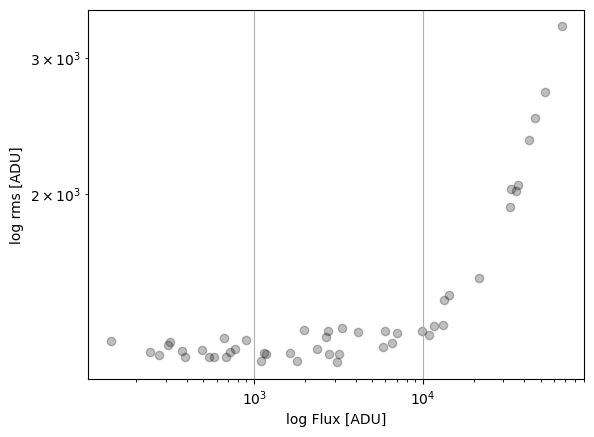

In [10]:
# plot of std vs median flux
plt.scatter(np.median(X, axis=0), np.std(X, axis=0)[:, None], alpha=0.25, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log Flux [ADU]')
plt.ylabel('log rms [ADU]')
plt.grid();

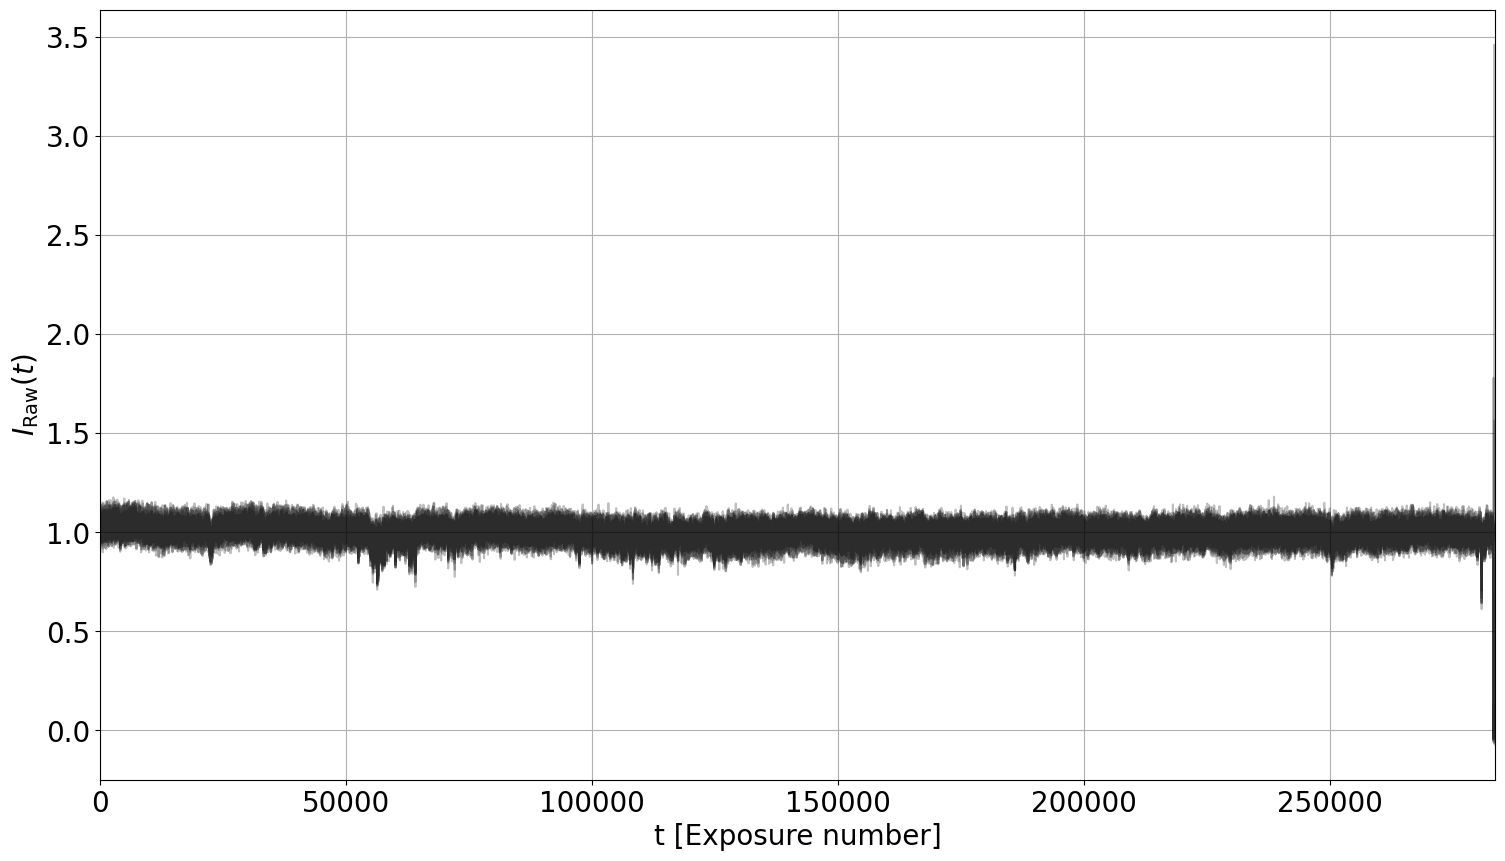

In [11]:
plt.figure(figsize=(18,10))
plt.plot(t, X_norm[:, stars], c='black', alpha=0.25)
plt.ylabel('$I_{\mathrm{Raw}}(t)$', fontsize=fs)
plt.xlabel('t [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.grid()
#plt.savefig('figures/Normalised_timeseries.png', bbox_inches='tight')

In [12]:
'''
fs = 20
fig, ax1 = plt.subplots(figsize=(18, 10))

ax1.plot(t, X_norm[:, stars], c='black', alpha=0.25)
ax1.set_ylabel('$I_{\mathrm{Raw}}(t)$', fontsize=fs)
ax1.set_xlabel('t [Exposure number]', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_xlim(0, t[-1])
ax1.grid()

# Create a twin of the existing y-axis to add an additional x-axis
ax2 = ax1.twiny()

# You can modify the below line to suit your specific requirements for the second x-axis
# Here, I'm setting it as an example with different tick positions and labels
ax2.set_xlim(ax1.get_xlim())  # Set the same limits as the original x-axis
ax2.set_xticks([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])  # Example tick positions
ax2.set_xticklabels((12e-3 * np.array([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])).astype(np.int64))  # Example tick labels
ax2.set_xlabel('Time [seconds]', fontsize=fs)  # Label for the additional x-axis
ax2.tick_params(labelsize=fs)  # Adjust tick label size if needed
plt.savefig('figures/Normalised_timeseries_v2.png', bbox_inches='tight')
'''

"\nfs = 20\nfig, ax1 = plt.subplots(figsize=(18, 10))\n\nax1.plot(t, X_norm[:, stars], c='black', alpha=0.25)\nax1.set_ylabel('$I_{\\mathrm{Raw}}(t)$', fontsize=fs)\nax1.set_xlabel('t [Exposure number]', fontsize=fs)\nax1.tick_params(labelsize=fs)\nax1.set_xlim(0, t[-1])\nax1.grid()\n\n# Create a twin of the existing y-axis to add an additional x-axis\nax2 = ax1.twiny()\n\n# You can modify the below line to suit your specific requirements for the second x-axis\n# Here, I'm setting it as an example with different tick positions and labels\nax2.set_xlim(ax1.get_xlim())  # Set the same limits as the original x-axis\nax2.set_xticks([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])  # Example tick positions\nax2.set_xticklabels((12e-3 * np.array([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])).astype(np.int64))  # Example tick labels\nax2.set_xlabel('Time [seconds]', fontsize=fs)  # Label for the additional x-axis\nax2.tick_params(labelsize=fs)  # Adjust tick label size if needed\nplt.savefig('figures/Normalised_timeser

In [13]:
'''
comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
print("Number of comparison stars:", len(comparison_stars))
wav = np.average(X_norm[:, comparison_stars],
                 weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)

plt.figure(figsize=(18,10))
plt.plot(t, wav, c='tab:purple', alpha=0.75)
plt.ylabel('$I_{WAV}(t)$', fontsize=fs)
plt.xlabel('t [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.grid()
plt.savefig('figures/wav.png', bbox_inches='tight')
'''

'\ncomparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]\nprint("Number of comparison stars:", len(comparison_stars))\nwav = np.average(X_norm[:, comparison_stars],\n                 weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)\n\nplt.figure(figsize=(18,10))\nplt.plot(t, wav, c=\'tab:purple\', alpha=0.75)\nplt.ylabel(\'$I_{WAV}(t)$\', fontsize=fs)\nplt.xlabel(\'t [Exposure number]\', fontsize=fs)\nplt.tick_params(labelsize=fs)\nplt.xlim(0, t[-1])\nplt.grid()\nplt.savefig(\'figures/wav.png\', bbox_inches=\'tight\')\n'

In [14]:
positions[9]

array([2928, 1582], dtype=int64)

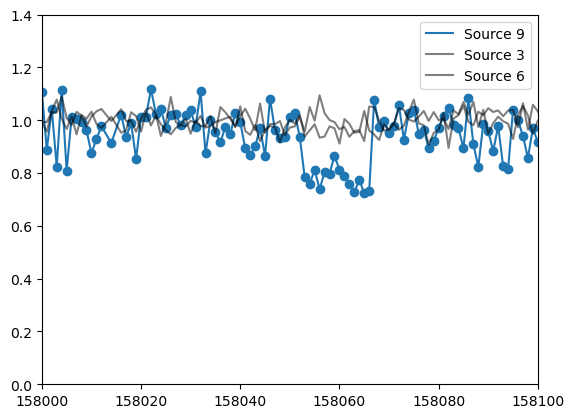

In [29]:
samples = [9, 3, 6] #, 15, 19]
#samples = [9, 15, 19]
for i in samples:
    # if the sample is in the comparison star set, exclude it
    if i == samples[0]:
        c, alpha = 'tab:blue', 1
    else:
        c, alpha = 'k', 0.5
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    #comparison_stars = np.arange(0, 10)
    comparison_stars = [c for c in comparison_stars if c != i]
    wav = np.average(X_norm[:, comparison_stars],
                     weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)
    plt.plot(t, X_norm[:, i] / wav, c=c, alpha=alpha, label='Source %d' % i)
    
    if i == samples[0]:
        plt.scatter(t, X_norm[:, i] / wav, c=c, alpha=alpha)
        
plt.xlim(158000, 158100)
#plt.xlim(157800, 158000)
plt.ylim(0.0, 1.4)
plt.legend()
plt.show();

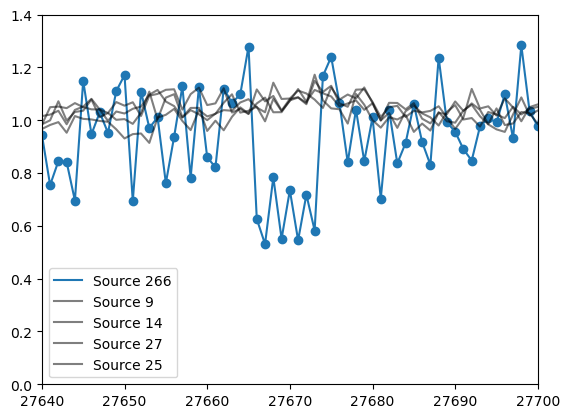

In [65]:
samples = [266, 9, 14, 27, 25]
for i in samples:
    # if the sample is in the comparison star set, exclude it
    if i == samples[0]:
        c, alpha = 'tab:blue', 1
    else:
        c, alpha = 'k', 0.5
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    comparison_stars = [c for c in comparison_stars if c != i]
    wav = np.average(X_norm[:, comparison_stars],
                     weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)
    plt.plot(t, X_norm[:, i] / wav, c=c, alpha=alpha, label='Source %d' % i)
    
    if i == samples[0]:
        plt.scatter(t, X_norm[:, i] / wav, c=c, alpha=alpha)
        
plt.xlim(27640, 27700)
plt.ylim(0.0, 1.4)
plt.legend()
plt.show();

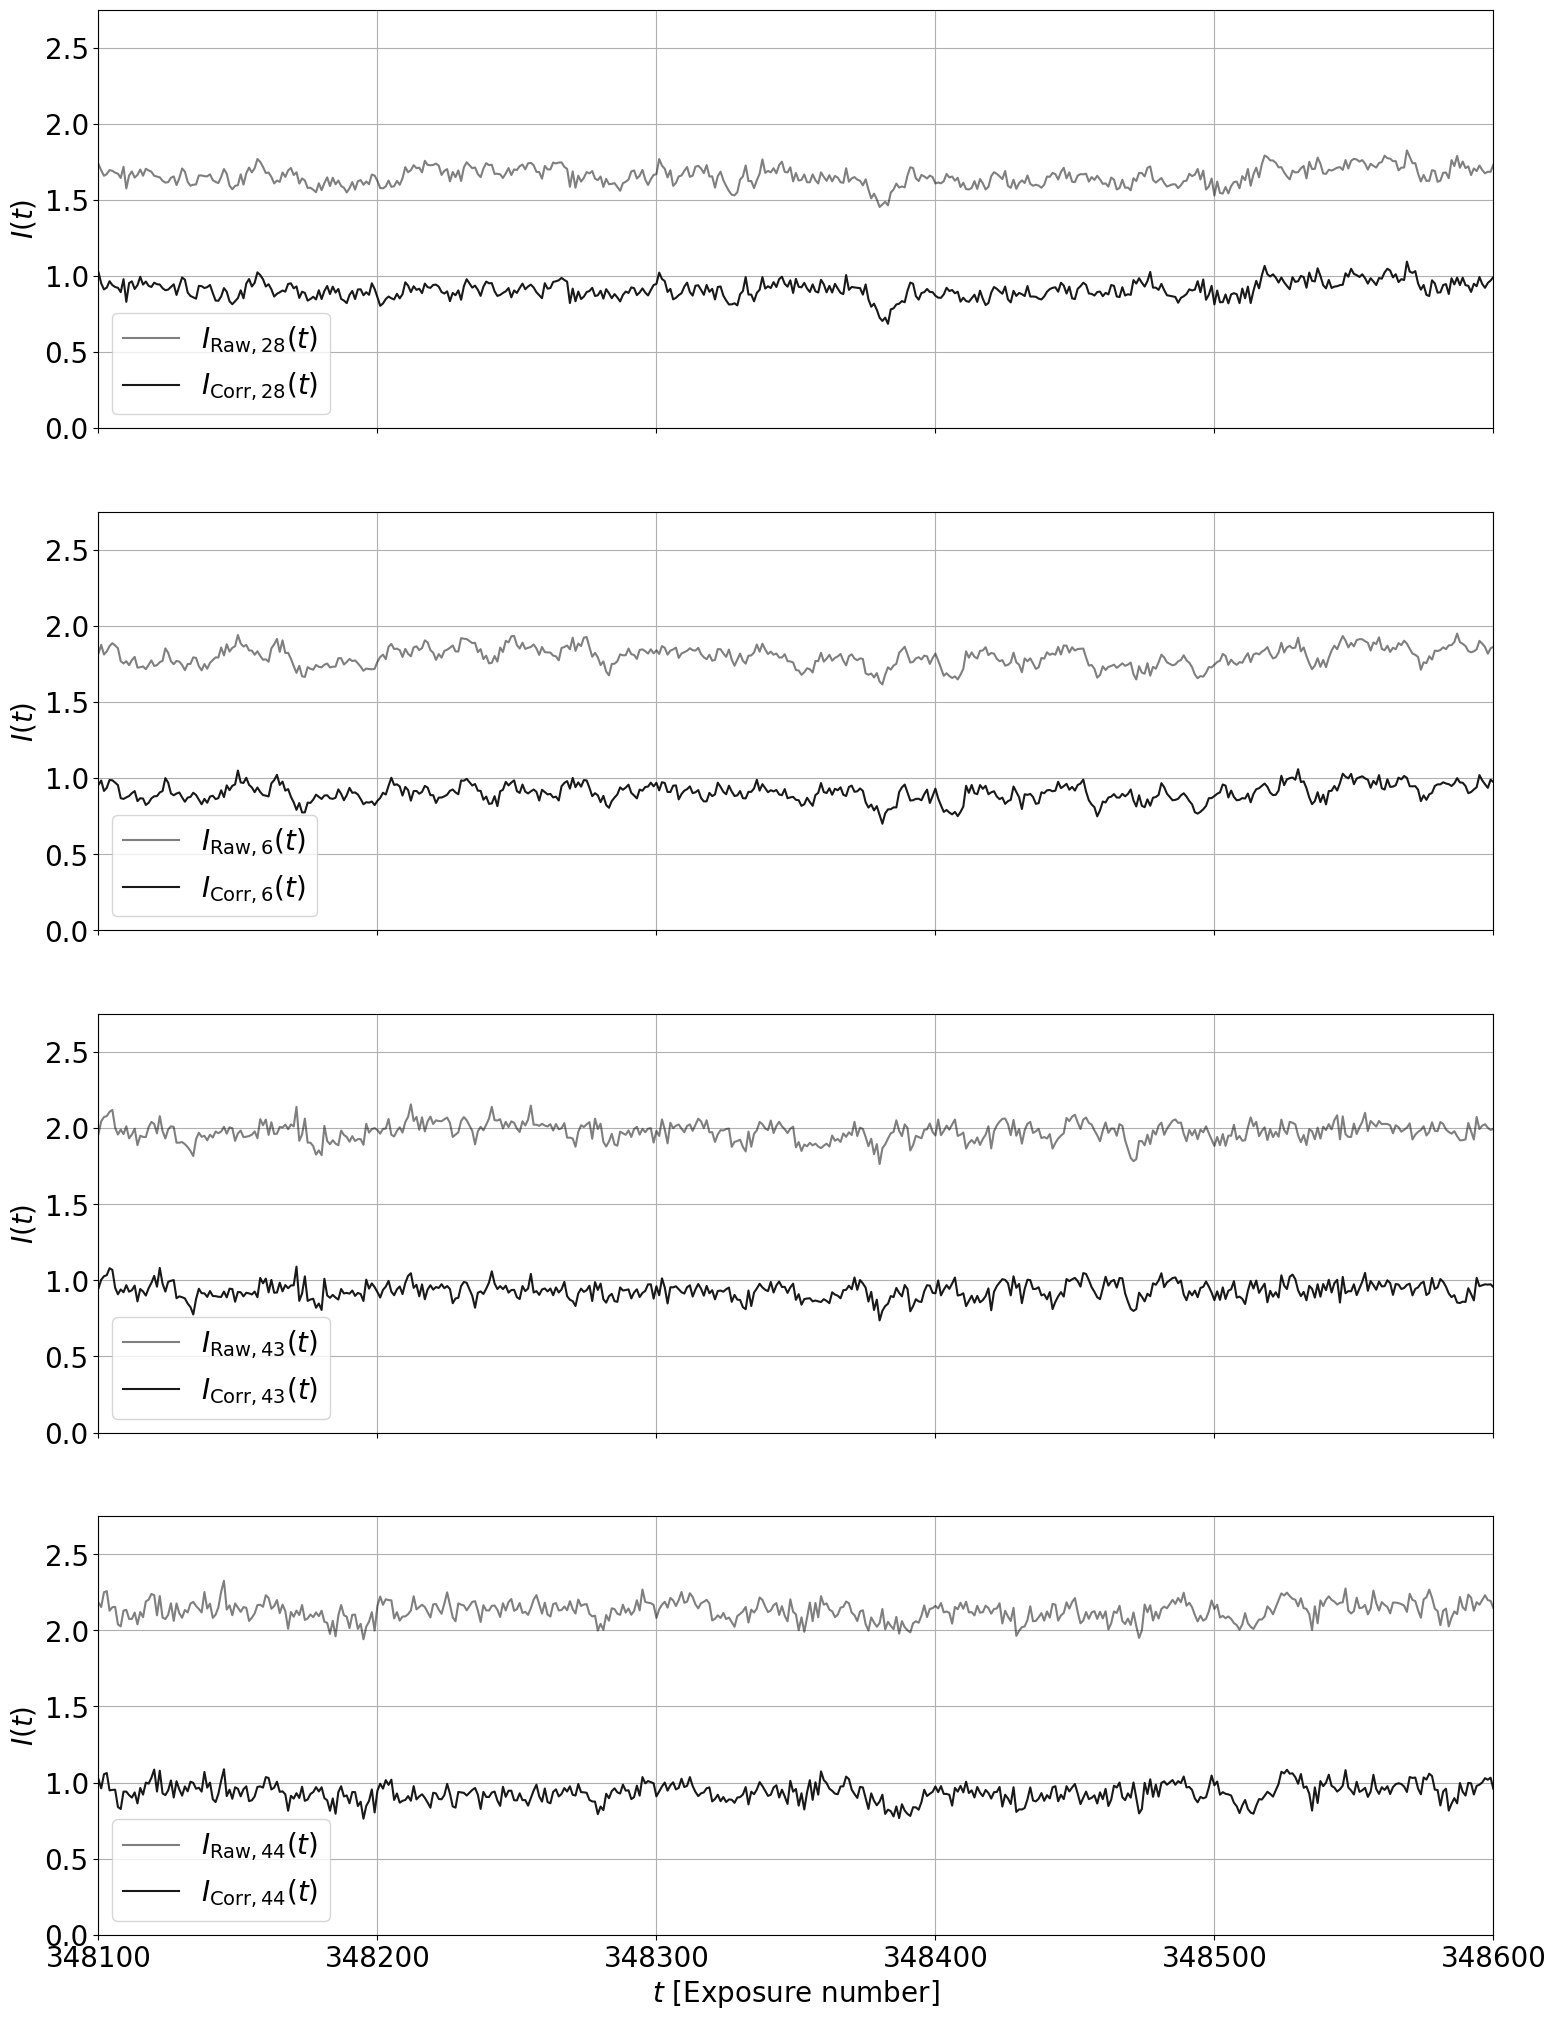

In [18]:
samples = [28, 6, 43, 44, 12, 81]
nrows = 4
fig, ax = plt.subplots(figsize=(18, 25), nrows=nrows, ncols=1)
for i in range(nrows):
    
    # if the sample is in the comparison star set, exclude it
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    comparison_stars = [c for c in comparison_stars if c != samples[i]]
    wav = np.average(X_norm[:, comparison_stars],
                     weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)
    
    ax[i].plot(t, (0.75 + 0.15*i) + (X_norm[:, samples[i]]), c='black', alpha=0.5,
               label='$I_{\mathrm{Raw}, %d}(t)$' % (samples[i]))
    ax[i].plot(t, X_norm[:, samples[i]] / wav, c='black', alpha=0.9,
               label='$I_{\mathrm{Corr}, %d}(t)$' % (samples[i]))
    ax[i].grid()
    ax[i].legend(loc='lower left', fontsize=fs)
    #ax[i].text(200000, 0.25, 'Source: $n=%d$' % (samples[i] + 1), fontsize=fs)
    ax[i].set_xlim(348100, 348600)
    ax[i].set_ylim(0, 2.75)
    ax[i].tick_params(labelsize=fs)
    
    ax[i].set_ylabel('$I(t)$', fontsize=fs)
    
    if i != 3:
        ax[i].axes.xaxis.set_ticklabels([])
    
    if i == 3:
        ax[i].set_xlabel('$t$ [Exposure number]', fontsize=fs)
        
        
#plt.savefig('figures/Raw_vs_Corr.png', bbox_inches='tight')

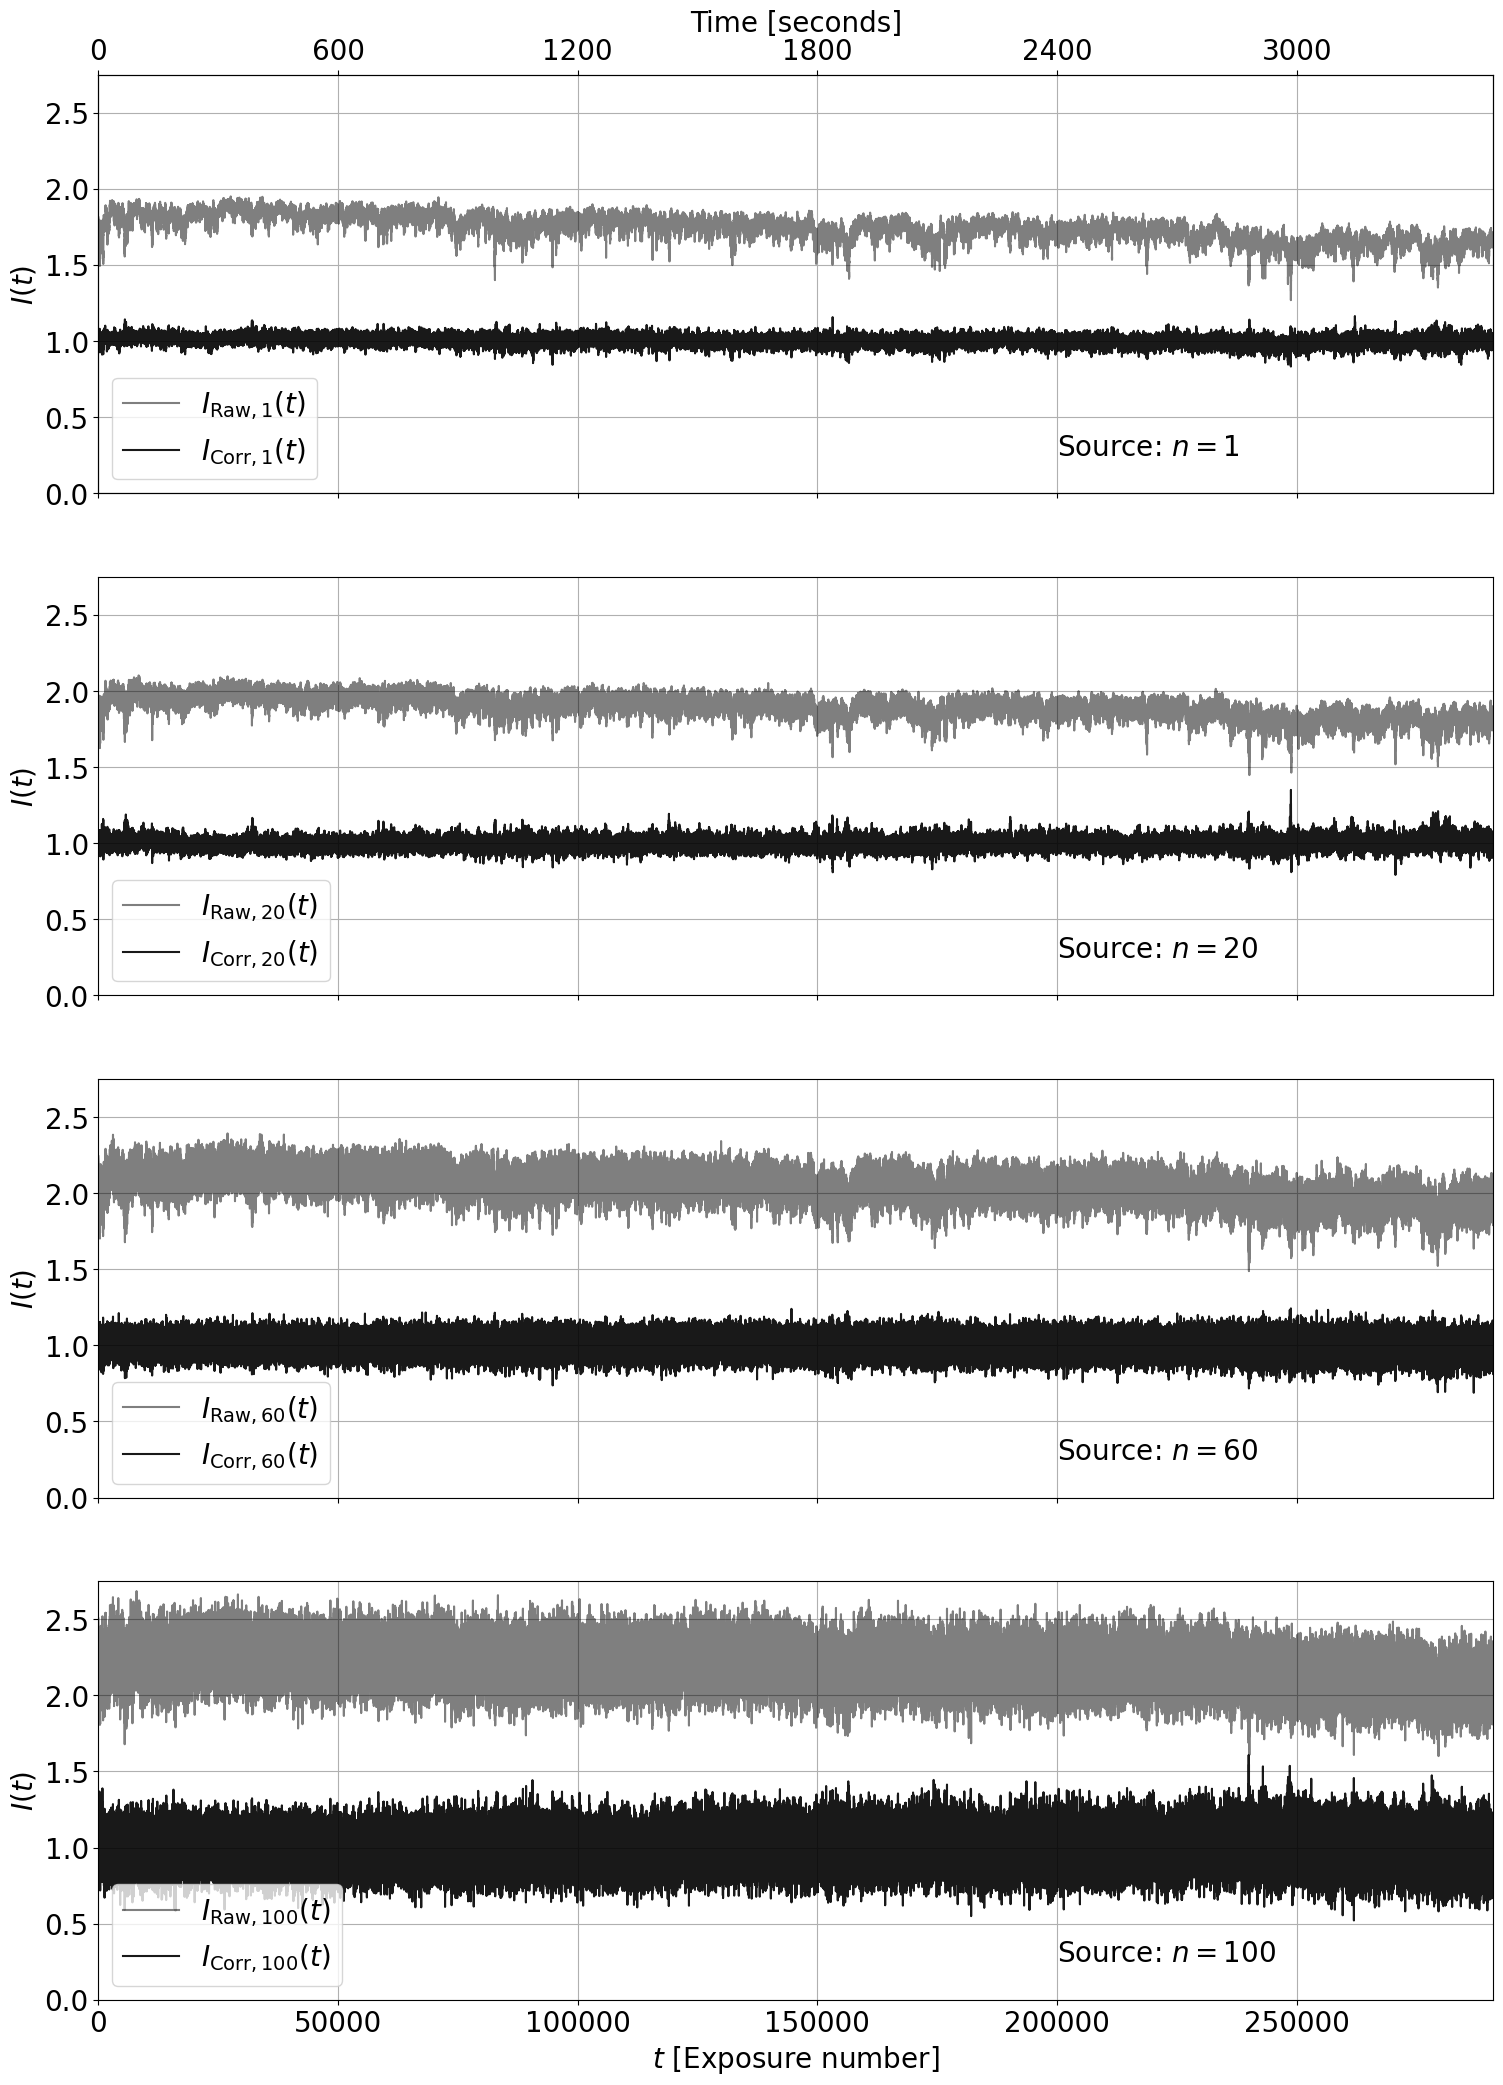

In [28]:
samples = [0, 19, 59, 99]
nrows = 4
fig, ax = plt.subplots(figsize=(18, 25), nrows=nrows, ncols=1)
for i in range(nrows):
    
    # if the sample is in the comparison star set, exclude it
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    comparison_stars = [c for c in comparison_stars if c != samples[i]]
    wav = np.average(X_norm[:, comparison_stars],
                     weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)
    
    ax[i].plot(t, (0.75 + 0.15*i) + (X_norm[:, samples[i]]), c='black', alpha=0.5,
               label='$I_{\mathrm{Raw}, %d}(t)$' % (samples[i] + 1))
    ax[i].plot(t, X_norm[:, samples[i]] / wav, c='black', alpha=0.9,
               label='$I_{\mathrm{Corr}, %d}(t)$' % (samples[i] + 1))
    ax[i].grid()
    ax[i].legend(loc='lower left', fontsize=fs)
    ax[i].text(200000, 0.25, 'Source: $n=%d$' % (samples[i] + 1), fontsize=fs)
    ax[i].set_xlim(0, t[-1])
    ax[i].set_ylim(0, 2.75)
    ax[i].tick_params(labelsize=fs)
    
    ax[i].set_ylabel('$I(t)$', fontsize=fs)
    
    if i != 3:
        ax[i].axes.xaxis.set_ticklabels([])
    
    if i == 3:
        ax[i].set_xlabel('$t$ [Exposure number]', fontsize=fs)
        
# You can modify the below line to suit your specific requirements for the second x-axis
# Here, I'm setting it as an example with different tick positions and labels
ax2 = ax[0].twiny()

# Customize the additional x-axis (change these according to your requirements)
ax2.set_xlim(ax[0].get_xlim())  # Set the same 
ax2.set_xticks([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])  # Example tick positions
ax2.set_xticklabels((12e-3 * np.array([0, 5e4, 1e5, 1.5e5, 2e5, 2.5e5])).astype(np.int64))  # Example tick labels
ax2.set_xlabel('Time [seconds]', fontsize=fs)  # Label for the additional x-axis
ax2.tick_params(labelsize=fs)  # Adjust tick label size if needed  
        
plt.savefig('figures/Raw_vs_Corr_v2.png', bbox_inches='tight')